In [ ]:
from tqdm import tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import Vocab
from torchtext import datasets
from torchtext.legacy.data import Field, LabelField, BucketIterator
from torchtext.legacy.datasets import TREC

In [157]:
text = Field(sequential = True, tokenize = "spacy", tokenizer_language="en", lower=True, batch_first=True, include_lengths = True)
target = LabelField()

In [158]:
train_data, test_data = TREC.splits(text_field = text, label_field = target)
train_data, val_data = train_data.split(split_ratio = 0.8)

In [159]:
text.build_vocab(train_data, max_size = 10000, min_freq = 2, vectors = "glove.6B.50d")

In [160]:
target.build_vocab(train_data)

In [161]:
vocab_size = len(text.vocab)
num_classes = len(target.vocab)

In [162]:
vocab_size

2963

In [ ]:
# An example from train data
print(train_data[0].text, train_data[0].label)

['how', 'can', 'i', 'get', 'someone', "'s", 'email', 'address', '?'] DESC


Dataset labels description:

*   HUM for questions about humans
*   ENTY for questions about entities
*   DESC for questions asking you for a description
*   NUM for questions where the answer is numerical
*   LOC for questions where the answer is a location
*   ABBR for questions asking about abbreviations

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [163]:
train_iter, val_iter, test_iter = BucketIterator.splits(
                                                  (train_data, val_data, test_data), 
                                                  batch_size = 32, 
                                                  sort_key=lambda x:len(x.text),
                                                  sort_within_batch=True,
                                                  shuffle=True,
                                                  device = device,
                                                  sort=False)

In [164]:
class TREC_model(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim, num_layers, drop):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop = drop

        self.dropout = nn.Dropout(self.drop)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()

    def init_weights(self):
        hidden_s = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
        cell_s = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)

    def forward(self, text, hidden, lengths):

        embedded = self.embedding(text)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True).to(device)
        out, (h, c) = self.lstm(packed, hidden)
        unpacked, len = nn.utils.rnn.pad_packed_sequence(out, batch_first = True)
        
        out = self.dropout(unpacked[:, -1, :])
        out = self.relu(out)
        out = self.fc(out)

        return out

In [178]:
embed_dim = 50
hidden_dim = 64
num_layers = 2
drop = 0.5
lr = 0.001

model = TREC_model(vocab_size, embed_dim, num_classes, hidden_dim, num_layers, drop).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

In [179]:
model.embedding.weight.data.copy_(text.vocab.vectors)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1458,  0.5046,  0.0475,  ..., -0.4147,  0.1105,  1.1681],
        ...,
        [-0.0052,  0.4748,  0.8903,  ...,  0.2017,  0.4701,  0.4411],
        [-0.5441,  1.0104, -0.4419,  ...,  0.4079,  0.4635, -1.7831],
        [-0.0263,  0.0535, -0.0091,  ..., -0.0457, -0.3948,  0.1020]])

In [15]:
criterion = nn.CrossEntropyLoss().to(device)

In [16]:
def accuracy(pred, label):
  return (pred.argmax(1) == label).sum().float()/label.shape[0]

In [180]:
accuracies = []
losses = []

def train_model(model, iter, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iter:

      optimizer.zero_grad()
      batch_size = len(batch.label)
      hidden_s = torch.zeros(num_layers, batch_size, hidden_dim)
      cell_s = torch.zeros(num_layers, batch_size, hidden_dim)
      
      pred = model(batch.text[0], (hidden_s, cell_s), batch.text[1])
      loss = criterion(pred.type(torch.FloatTensor), batch.label)
      accuracy_ = accuracy(pred, batch.label)

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 5)
      optimizer.step()
      
      epoch_loss += loss.item()
      epoch_acc += accuracy_.item()
    
    # scheduler.step()

    return epoch_loss/len(iter), epoch_acc/len(iter)*100

In [181]:
accuracies_val = []
losses_val = []

def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    
    for batch in iterator :

      batch_size = len(batch.label)
      hidden_s = torch.zeros(num_layers, batch_size, hidden_dim)
      cell_s = torch.zeros(num_layers, batch_size, hidden_dim)
      
      pred = model(batch.text[0], (hidden_s, cell_s), batch.text[1])
      
      loss = criterion(pred.type(torch.FloatTensor), batch.label)
      acc = accuracy(pred, batch.label)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator) * 100

In [182]:
epochs = 50

for epoch in range(epochs):

    loss_tr, acc_tr = train_model(model, train_iter,optimizer, criterion)
    loss_val, acc_val = evaluate(model, test_iter, criterion)

    losses.append(loss_tr)
    accuracies.append(acc_tr)
    losses_val.append(loss_val)
    accuracies_val.append(acc_val)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {loss_tr:.3f} | Train Acc: {acc_tr:.2f}%')
    print(f'\tVal. Loss: {loss_val:.3f} |  Val. Acc: {acc_val:.2f}%')

Epoch: 01
	Train Loss: 1.637 | Train Acc: 29.94%
	Val. Loss: 1.410 |  Val. Acc: 44.65%
Epoch: 02
	Train Loss: 1.147 | Train Acc: 58.35%
	Val. Loss: 1.039 |  Val. Acc: 63.87%
Epoch: 03
	Train Loss: 0.949 | Train Acc: 66.67%
	Val. Loss: 0.938 |  Val. Acc: 65.04%
Epoch: 04
	Train Loss: 0.821 | Train Acc: 70.45%
	Val. Loss: 0.857 |  Val. Acc: 66.02%
Epoch: 05
	Train Loss: 0.731 | Train Acc: 73.91%
	Val. Loss: 0.799 |  Val. Acc: 67.58%
Epoch: 06
	Train Loss: 0.679 | Train Acc: 75.69%
	Val. Loss: 0.799 |  Val. Acc: 65.62%
Epoch: 07
	Train Loss: 0.590 | Train Acc: 79.49%
	Val. Loss: 0.784 |  Val. Acc: 71.45%
Epoch: 08
	Train Loss: 0.596 | Train Acc: 79.91%
	Val. Loss: 0.743 |  Val. Acc: 70.94%
Epoch: 09
	Train Loss: 0.541 | Train Acc: 81.14%
	Val. Loss: 0.724 |  Val. Acc: 71.05%
Epoch: 10
	Train Loss: 0.492 | Train Acc: 83.94%
	Val. Loss: 0.768 |  Val. Acc: 68.91%
Epoch: 11
	Train Loss: 0.460 | Train Acc: 84.60%
	Val. Loss: 0.707 |  Val. Acc: 71.52%
Epoch: 12
	Train Loss: 0.451 | Train Acc: 8

In [183]:
loss_test, acc_test = evaluate(model, test_iter, criterion)
print(f' Test. Loss: {loss_test:.3f} |  Test. Acc: {acc_test:.2f}%')

 Test. Loss: 0.834 |  Test. Acc: 73.48%


In [186]:
# Save the model for later use
torch.save(model.state_dict(), 'trec_model.pt')

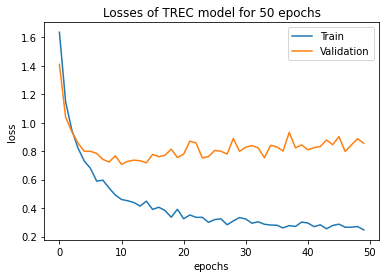

In [184]:
import matplotlib.pyplot as plt

plt.plot(losses, label = "Train")
plt.plot(losses_val, label = "Validation")
plt.title("Losses of TREC model for 50 epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

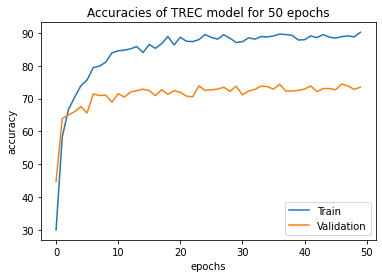

In [185]:
plt.plot(accuracies, label = "Train")
plt.plot(accuracies_val, label = "Validation")
plt.title("Accuracies of TREC model for 50 epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [131]:
import spacy
nlp = spacy.load("en")

def predict_class(model, sentence, min_len = 4):

    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))

    indexed = [text.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    h_t = torch.zeros(num_layers,1, hidden_dim)
    c_t = torch.zeros(num_layers,1, hidden_dim)
    length = torch.tensor([len(tokenized)], dtype = torch.int64)
    preds = model(tensor, (h_t, c_t), length)
    max_preds = preds.argmax(dim = 1)

    return target.vocab.itos[max_preds.item()]

In [ ]:
model.load_state_dict(torch.load('trec_model.pt'))

In [187]:
predict_class(model, "How much does it cost?")

'NUM'